Shape: (5000, 11)
Target distribution:
admitted_numeric
0    0.5208
1    0.4792
Name: proportion, dtype: float64
Train size: (4000, 5)
Test size: (1000, 5)

Model Accuracy: 0.859

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       521
           1       0.88      0.81      0.85       479

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



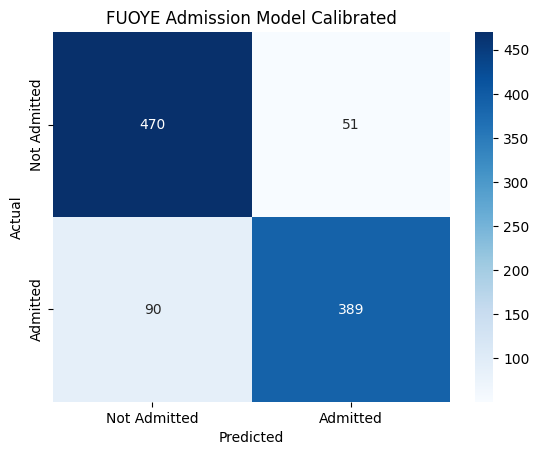

FUOYE model saved successfully!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV 
import joblib
import os

# Load FUOYE processed dataset
fuoye_df = pd.read_csv("../../Data/FUOYE_processed.csv")
print("Shape:", fuoye_df.shape)
fuoye_df.head()

# Ensure no missing target values
fuoye_df = fuoye_df.dropna(subset=['admitted_numeric'])
fuoye_df["admitted_numeric"] = fuoye_df["admitted_numeric"].astype(int)

print("Target distribution:")
print(fuoye_df["admitted_numeric"].value_counts(normalize=True))


# Features and target
X = fuoye_df[
    ['UTME_Score', 'Faculty', 'Department',
     'Olevel_Valid', 'olevel_avg_points']
]
y = fuoye_df['admitted_numeric']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Preprocessing
categorical_features = ['Faculty', 'Department']
numeric_features = [
    'UTME_Score', 'Olevel_Valid', 'olevel_avg_points'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# Random Forest
base_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "rf",
            RandomForestClassifier(
                n_estimators=300,
                max_depth=12,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1,
                class_weight="balanced"
            ),
        ),
    ]
)


# Probability Calibration
calibrated_model = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train, y_train)

# EVALUATION
y_pred = calibrated_model.predict(X_test)
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)

print("\nModel Accuracy:", round(accuracy, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Not Admitted", "Admitted"],
    yticklabels=["Not Admitted", "Admitted"]
)
plt.title("FUOYE Admission Model Calibrated")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Save model
os.makedirs("../../Models", exist_ok=True)
joblib.dump(calibrated_model, "../../Models/fuoye_admission_model.pkl")
print("FUOYE model saved successfully!")